Import useful libraries

In [1]:
import numpy as np
from matplotlib import pyplot as plt 
from pandas import read_csv
import sys
import os
from matplotlib import rcParams
import toml

%load_ext autoreload
%autoreload 2

In [2]:
import ctypes

lib_path = "/home/matteo/Downloads/ac/build/"

class ACreturn(ctypes.Structure):
	_fields_ = [ ("average", ctypes.c_double), ("sigmaF", ctypes.c_double), ("sigmaF_error", ctypes.c_double), ("ACtime", ctypes.c_double), ("ACtimeError", ctypes.c_double) ]


def ComputeStatistics(data):
	ft_lib = ctypes.cdll.LoadLibrary(lib_path + "libac.so")

	arg = (ctypes.c_double * len(data))(*data)
	avg = ft_lib.Wrapper
	avg.restype = ACreturn

	return avg(arg, len(data))

# Block spin analysis

Specify folders from which to get configurations and set the values of the yukawa couling used in the simulations

In [14]:
################################################################################
# dataset 1
'''folders = ["dataset1/s_0_25/conf" + str(i+1) for i in range(10)] 
folders += ["dataset1/s_0_5/conf" + str(i+1) for i in range(10)] 
folders += ["dataset1/s_1_0/conf" + str(i+1) for i in range(10)]'''

# dataset 2
'''folders = ["dataset2/s_0_5/conf" + str(i+1) for i in range(10)] 
folders += ["dataset2/s_1_0/conf" + str(i+1) for i in range(10)]'''

# Almost phase transition, plot around mphi2 = 0
'''folders = ["phase_trans_1/conf" + str(i+1) for i in range(16)] 
folders  += ["phase_trans_2/conf" + str(i+1) for i in range(16)]'''

# dataset 6
#folders = ["yukawa_scan/conf" + str(i+1) for i in range(17)]

# yukawa scan
folders = ["simu/yukawa_scan_1/conf" + str(i) for i in range(1, 18)]
folders += ["simu/yukawa_scan_2/conf" + str(i) for i in range(1, 18)]
folders += ["simu/yukawa_scan_4/conf" + str(i) for i in range(18, 35)]

Nt0 = 16
Nx0 = 16

colors = ['blue', 'orange', 'green', 'red']
################################################################################

Import functions from Jan Philipp's code

In [15]:
from correlations import *
from read_in_data import *
from mass_fit import *
from mass_matteo import *

In [16]:
def get_chi2xxx(cfgs: np.ndarray, myV):
    """Return mean and error of suceptibility."""
    V = np.prod(cfgs.shape[1:])
    print("dsjfdsomfosdmfodskmfosdkmf" + str(V))
    axis = tuple([i+1 for i in range(len(cfgs.shape)-1)])
    mags = cfgs.mean(axis=axis)
    #return jackknife(V * (mags**2 - mags.mean()**2))
    return jackknife(myV * ((mags - mags.mean())**2))
    #return jackknife(V * (mags**2))

Load data from specified folders

In [17]:
phi = {}
cond = {}
absphi = {}
chi2 = {}
mr = {}
mqphys = {}
cutoffs = []

for f in folders:
    print(f)
    params = toml.load("data/" + f + "/input.toml") # read toml file with parameters

    s = str(params['physics']['cutFraction']) # read cutoff
    # if cutoff is not already in the list, add it and create the corresponding data arrays
    if not (float(s) in cutoffs):
        cutoffs.append(float(s))
        phi[s] = []
        cond[s] = []
        chi2[s] = []
        mr[s] = []
        mqphys[s] = []

    Nt = int(Nt0 / float(s))
    Nx = int(Nx0 / float(s))
    volume = (Nt, Nx)
    
    p = float(params['fermions']['yukawa_coupling']) # read yukawa coupling
    if p == 0:
        p = 1e-5
    
    print("cutFractions:", s, " g:", p)

    data = read_csv("data/" + f + "/traces.csv") # read file with magnetisation, condensate, ...

    # Get bosonic time slices computed in main.cu
    S_t = get_time_slices_from_timeslicefile("data/" + f + "/slice.dat", field_axis=0, return_all=False)
    # Get fermionic time slices computed in main.cu
    data_Sq_t = read_csv("data/" + f + "/data.csv")
    Sq_t = data_Sq_t['corr'].to_numpy(np.dtype('f8')).reshape((-1, Nt))

    # magnetisation
    blob = ComputeStatistics(data['sigma'])
    val, err = get_abs_mag(data['sigma'].to_numpy()) # !!!!!!!!!!!!!!!!!!!!!!!!! ABSSSSSSSSSSSSSSSSS
    phi[s].append((blob.average, blob.sigmaF, p))
    
    avgxxx = blob.average
    print(blob.average)
    print(blob.sigmaF)
    print(blob.sigmaF_error)
    print(blob.ACtime)
    print(blob.ACtimeError)
    
    # condensate
    val, err = get_mag(data['tr'].to_numpy())
    blob = ComputeStatistics(data['tr'])
    cond[s].append((blob.average, blob.sigmaF, p))
    # susceptibility
    val, err = get_chi2xxx(data['sigma'].to_numpy(), Nx*Nt)
    blob = ComputeStatistics((data['sigma'] - avgxxx)**2)
    chi2[s].append((blob.average, blob.sigmaF, p))
    # renormalised bosonic mass
    val, err = get_ren_mass_right_via_timeslices(S_t,volume)
    mr[s].append((val, err, p))
    # physical quark mass
    val, err = get_phys_quark_mass_via_timeslices(Sq_t,volume)
    print(s, p, blob.average, blob.sigmaF)
    mqphys[s].append((val, err, p))

    
    print()

for k in phi.keys():
    phi[k] = sorted(phi[k], key=lambda x: x[2])
    cond[k] = sorted(cond[k], key=lambda x: x[2])
    chi2[k] = sorted(chi2[k], key=lambda x: x[2])
    mr[k] = sorted(mr[k], key=lambda x: x[2])
    mqphys[k] = sorted(mqphys[k], key=lambda x: x[2])

simu/yukawa_scan_1/conf1
cutFractions: 1.0  g: -3.0


100%|██████████████████████████████████| 29850/29850 [00:00<00:00, 49622.69it/s]


-3.212260660971512
0.00046594187231732925
7.862651662326093e-06
0.9454617158474623
0.03008193295466273


100%|██████████████████████████████████| 29850/29850 [00:00<00:00, 49990.71it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|██████████████████████████████████| 29850/29850 [00:00<00:00, 50254.82it/s]


1.0 -3.0 0.003426939017844522 3.1037645048045266e-05

simu/yukawa_scan_1/conf2
cutFractions: 1.0  g: -2.0


100%|██████████████████████████████████| 29847/29847 [00:00<00:00, 50535.70it/s]


-3.170428180721693
0.0004904887171450476
8.277289436807231e-06
0.9913214617023856
0.03144676080593327


100%|██████████████████████████████████| 29847/29847 [00:00<00:00, 50191.62it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|██████████████████████████████████| 29847/29847 [00:00<00:00, 49142.29it/s]


1.0 -2.0 0.0036214741639834574 3.319395151732044e-05

simu/yukawa_scan_1/conf3
cutFractions: 1.0  g: -1.0


100%|██████████████████████████████████| 29847/29847 [00:00<00:00, 52166.50it/s]


-3.069026796998006
0.0005523291116917468
1.0359582205837911e-05
1.131221037158942
0.04008377561269732


100%|██████████████████████████████████| 29847/29847 [00:00<00:00, 52986.88it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|██████████████████████████████████| 29847/29847 [00:00<00:00, 50968.85it/s]


1.0 -1.0 0.004024261438723903 3.811892836278366e-05

simu/yukawa_scan_1/conf4
cutFractions: 1.0  g: -0.5


100%|██████████████████████████████████| 29846/29846 [00:00<00:00, 52221.98it/s]


-2.934775555853367
0.0006429656979520229
1.262099680803076e-05
1.3094996292712122
0.04839383759586433


100%|██████████████████████████████████| 29846/29846 [00:00<00:00, 51500.44it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|██████████████████████████████████| 29846/29846 [00:00<00:00, 53436.85it/s]


1.0 -0.5 0.004710730786119731 4.6824309640952504e-05

simu/yukawa_scan_1/conf5
cutFractions: 1.0  g: -0.2


100%|██████████████████████████████████| 29849/29849 [00:00<00:00, 52711.46it/s]


-2.7508261415792754
0.0007825787609707783
1.664294003127665e-05
1.562061481750232
0.06247811167554896


100%|██████████████████████████████████| 29849/29849 [00:00<00:00, 50369.99it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|██████████████████████████████████| 29849/29849 [00:00<00:00, 51022.02it/s]


1.0 -0.2 0.005850761091719167 6.276390742392284e-05

simu/yukawa_scan_1/conf6
cutFractions: 1.0  g: -0.1


100%|██████████████████████████████████| 29844/29844 [00:00<00:00, 53901.11it/s]


2.3225072309341774
0.0014037507262722726
3.939085517520836e-05
2.8562943858392082
0.15024439349654561


100%|██████████████████████████████████| 29844/29844 [00:00<00:00, 52734.23it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|██████████████████████████████████| 29844/29844 [00:00<00:00, 52824.91it/s]


1.0 -0.1 0.010292504122944886 0.00014349574812978988

simu/yukawa_scan_1/conf7
cutFractions: 1.0  g: -0.05


100%|██████████████████████████████████| 29848/29848 [00:00<00:00, 53382.53it/s]


2.4081195366523724
0.001205866192787556
3.160228112536961e-05
2.425375314028958
0.11936746602313106


100%|██████████████████████████████████| 29848/29848 [00:00<00:00, 53896.94it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|██████████████████████████████████| 29848/29848 [00:00<00:00, 53241.91it/s]


1.0 -0.05 0.008946105972383163 0.00011599440884141206

simu/yukawa_scan_1/conf8
cutFractions: 1.0  g: -0.01


100%|██████████████████████████████████| 29846/29846 [00:00<00:00, 52773.22it/s]


2.478938360584325
0.0010908132243541032
2.7157712804438898e-05
2.187469574882185
0.10227974036380319


100%|██████████████████████████████████| 29846/29846 [00:00<00:00, 52483.91it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|██████████████████████████████████| 29846/29846 [00:00<00:00, 52070.52it/s]


1.0 -0.01 0.008116173460024202 9.904600412553077e-05

simu/yukawa_scan_1/conf9
cutFractions: 1.0  g: 1e-05


100%|██████████████████████████████████| 29848/29848 [00:00<00:00, 52344.82it/s]


2.495810364513537
0.001071591949058633
2.667827151686435e-05
2.169214462594096
0.10147952055437136


100%|██████████████████████████████████| 29848/29848 [00:00<00:00, 53882.83it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|██████████████████████████████████| 29848/29848 [00:00<00:00, 51961.92it/s]


1.0 1e-05 0.00789911764023161 9.63628989401618e-05

simu/yukawa_scan_1/conf10
cutFractions: 1.0  g: 0.01


100%|██████████████████████████████████| 29849/29849 [00:00<00:00, 51723.32it/s]


2.512163290562501
0.0010364876773690658
2.5096795655616244e-05
2.075724503194867
0.09437070545074086


100%|██████████████████████████████████| 29849/29849 [00:00<00:00, 49214.85it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|██████████████████████████████████| 29849/29849 [00:00<00:00, 49898.96it/s]


1.0 0.01 0.007723213290642965 9.41005709152789e-05

simu/yukawa_scan_1/conf11
cutFractions: 1.0  g: 0.05


100%|██████████████████████████████████| 29846/29846 [00:00<00:00, 52280.15it/s]


2.574178447028083
0.000962884211664208
2.263982004289037e-05
1.920089326582608
0.0848761737947167


100%|██████████████████████████████████| 29846/29846 [00:00<00:00, 51990.85it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|██████████████████████████████████| 29846/29846 [00:00<00:00, 51234.18it/s]


1.0 0.05 0.007204884379686398 8.414150951157367e-05

simu/yukawa_scan_1/conf12
cutFractions: 1.0  g: 0.1


100%|██████████████████████████████████| 29845/29845 [00:00<00:00, 50270.31it/s]


2.6413337838833812
0.0009034098790310648
2.0588034761243797e-05
1.8173557044693007
0.07782500567023794


100%|██████████████████████████████████| 29845/29845 [00:00<00:00, 49590.91it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|██████████████████████████████████| 29845/29845 [00:00<00:00, 52248.87it/s]


1.0 0.1 0.006700673863145788 7.61311161969546e-05

simu/yukawa_scan_1/conf13
cutFractions: 1.0  g: 0.2


100%|██████████████████████████████████| 29847/29847 [00:00<00:00, 53448.27it/s]


2.746652883371869
0.0007955385555605025
1.691912012529413e-05
1.6015365569156539
0.06395315134451904


100%|██████████████████████████████████| 29847/29847 [00:00<00:00, 51686.14it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|██████████████████████████████████| 29847/29847 [00:00<00:00, 48425.53it/s]


1.0 0.2 0.005896709476371399 6.427398723165698e-05

simu/yukawa_scan_1/conf14
cutFractions: 1.0  g: 0.5


100%|██████████████████████████████████| 29845/29845 [00:00<00:00, 50776.01it/s]


2.9311245736304286
0.0006389584702943422
1.2542547668586708e-05
1.2837363072318198
0.047502457202813694


100%|██████████████████████████████████| 29845/29845 [00:00<00:00, 50782.93it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|██████████████████████████████████| 29845/29845 [00:00<00:00, 51432.32it/s]


1.0 0.5 0.004745409472337048 4.675077423244457e-05

simu/yukawa_scan_1/conf15
cutFractions: 1.0  g: 1.0


100%|██████████████████████████████████| 29846/29846 [00:00<00:00, 50471.25it/s]


3.066641334182141
0.0005616182383425135
1.0533987171072955e-05
1.1407711967218055
0.04040224591920982


100%|██████████████████████████████████| 29846/29846 [00:00<00:00, 50915.32it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|██████████████████████████████████| 29846/29846 [00:00<00:00, 51155.76it/s]


1.0 1.0 0.00412578716590074 3.963069319160338e-05

simu/yukawa_scan_1/conf16
cutFractions: 1.0  g: 2.0


100%|██████████████████████████████████| 29850/29850 [00:00<00:00, 51376.70it/s]


3.1677535363484295
0.000485327607674069
8.189781060613517e-06
0.9774116442480749
0.03103265871586088


100%|██████████████████████████████████| 29850/29850 [00:00<00:00, 51839.76it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|██████████████████████████████████| 29850/29850 [00:00<00:00, 50525.01it/s]


1.0 2.0 0.0035964862035545516 3.2574171561561456e-05

simu/yukawa_scan_1/conf17
cutFractions: 1.0  g: 3.0


100%|██████████████████████████████████| 29846/29846 [00:00<00:00, 49313.30it/s]


3.2097941707431232
0.00046436658522851633
7.83659417225518e-06
0.9328101696226345
0.029706228336095104


100%|██████████████████████████████████| 29846/29846 [00:00<00:00, 46855.24it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|██████████████████████████████████| 29846/29846 [00:00<00:00, 47621.68it/s]


1.0 3.0 0.003449511976419803 3.1519540113610284e-05

simu/yukawa_scan_2/conf1
cutFractions: 0.5  g: -3.0


100%|██████████████████████████████████| 29848/29848 [00:00<00:00, 52428.25it/s]


-3.2113121240954006
0.000935162270223073
2.9893672909525427e-05
3.8414246270279246
0.22960596285611162


100%|██████████████████████████████████| 29848/29848 [00:00<00:00, 52014.81it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|██████████████████████████████████| 29848/29848 [00:00<00:00, 52289.92it/s]


0.5 -3.0 0.003396685238988636 5.079754122383274e-05

simu/yukawa_scan_2/conf2
cutFractions: 0.5  g: -2.0


100%|██████████████████████████████████| 29846/29846 [00:00<00:00, 52977.53it/s]


-3.1694695017757804
0.00098043219886253
3.1851491613220724e-05
4.017194836917816
0.24380373448356496


100%|██████████████████████████████████| 29846/29846 [00:00<00:00, 50735.79it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|██████████████████████████████████| 29846/29846 [00:00<00:00, 47607.55it/s]


0.5 -2.0 0.0035698641975370686 5.510760134798445e-05

simu/yukawa_scan_2/conf3
cutFractions: 0.5  g: -1.0


100%|██████████████████████████████████| 29847/29847 [00:00<00:00, 46838.65it/s]


-3.0681229939357757
0.0011108293227163595
3.830991329766228e-05
4.5707204382713655
0.29427218503028174


100%|██████████████████████████████████| 29847/29847 [00:00<00:00, 46216.18it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|██████████████████████████████████| 29847/29847 [00:00<00:00, 45232.85it/s]


0.5 -1.0 0.004027615306357813 6.597720934891035e-05

simu/yukawa_scan_2/conf4
cutFractions: 0.5  g: -0.5


100%|██████████████████████████████████| 29851/29851 [00:00<00:00, 45944.33it/s]


-2.9341507979632078
0.0013090056796999175
4.821582479245833e-05
5.428023287276327
0.3721108879867424


100%|██████████████████████████████████| 29851/29851 [00:00<00:00, 47566.21it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|██████████████████████████████████| 29851/29851 [00:00<00:00, 50395.57it/s]


0.5 -0.5 0.004709911052507194 8.239188394896056e-05

simu/yukawa_scan_2/conf5
cutFractions: 0.5  g: -0.2


100%|██████████████████████████████████| 29850/29850 [00:00<00:00, 50432.01it/s]


-2.751161492797306
0.0016194241365183107
6.52768681138553e-05
6.69550620774089
0.5011326851342002


100%|██████████████████████████████████| 29850/29850 [00:00<00:00, 50103.70it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|██████████████████████████████████| 29850/29850 [00:00<00:00, 48318.17it/s]


0.5 -0.2 0.005843296142830183 0.00011416296253169207

simu/yukawa_scan_2/conf6
cutFractions: 0.5  g: -0.1


100%|██████████████████████████████████| 29847/29847 [00:00<00:00, 50876.38it/s]


2.3249548604549855
0.0028313771696280073
0.0001452052140836517
11.621488813390203
1.1002331336231759


100%|██████████████████████████████████| 29847/29847 [00:00<00:00, 51034.34it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|██████████████████████████████████| 29847/29847 [00:00<00:00, 49752.42it/s]


0.5 -0.1 0.010286504279002715 0.00030049176370452774

simu/yukawa_scan_2/conf7
cutFractions: 0.5  g: -0.05


100%|██████████████████████████████████| 29849/29849 [00:00<00:00, 50032.40it/s]


2.4078598277999355
0.002453312224680539
0.00011838054422478655
10.052952112873594
0.8972714778787136


100%|██████████████████████████████████| 29849/29849 [00:00<00:00, 48759.56it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|██████████████████████████████████| 29849/29849 [00:00<00:00, 50067.82it/s]


0.5 -0.05 0.008929364377369934 0.0002332929383617778

simu/yukawa_scan_2/conf8
cutFractions: 0.5  g: -0.01


100%|██████████████████████████████████| 29847/29847 [00:00<00:00, 52360.71it/s]


2.4790190555164666
0.002223274129241913
0.00010254855243106454
9.111796535734157
0.7779219452284389


100%|██████████████████████████████████| 29847/29847 [00:00<00:00, 47615.74it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|██████████████████████████████████| 29847/29847 [00:00<00:00, 49038.83it/s]


0.5 -0.01 0.008090746287227365 0.00019864606530483884

simu/yukawa_scan_2/conf9
cutFractions: 0.5  g: 1e-05


100%|██████████████████████████████████| 29849/29849 [00:00<00:00, 51450.52it/s]


2.4959869416060902
0.0021651662797543734
9.827972207548855e-05
8.824706970462836
0.7414278172757233


100%|██████████████████████████████████| 29849/29849 [00:00<00:00, 49911.89it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|██████████████████████████████████| 29849/29849 [00:00<00:00, 49661.71it/s]


0.5 1e-05 0.007923666553824201 0.00019197308944470022

simu/yukawa_scan_2/conf10
cutFractions: 0.5  g: 0.01


100%|██████████████████████████████████| 29850/29850 [00:00<00:00, 49998.25it/s]


2.512547122278036
0.0021218441325782495
9.552542921177184e-05
8.660236441033899
0.7218036655355574


100%|██████████████████████████████████| 29850/29850 [00:00<00:00, 49264.87it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|██████████████████████████████████| 29850/29850 [00:00<00:00, 53545.02it/s]


0.5 0.01 0.007754619485728726 0.00018481039232842882

simu/yukawa_scan_2/conf11
cutFractions: 0.5  g: 0.05


100%|██████████████████████████████████| 29848/29848 [00:00<00:00, 50871.84it/s]


2.573832048713475
0.0019708661580979192
8.650345157269088e-05
8.081800039617619
0.6576940905813666


100%|██████████████████████████████████| 29848/29848 [00:00<00:00, 50077.94it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|██████████████████████████████████| 29848/29848 [00:00<00:00, 49059.17it/s]


0.5 0.05 0.007168974898519881 0.0001620191516397306

simu/yukawa_scan_2/conf12
cutFractions: 0.5  g: 0.1


100%|██████████████████████████████████| 29847/29847 [00:00<00:00, 50221.36it/s]


2.6405617485844424
0.0018220460357773714
7.714111180064521e-05
7.475801922762595
0.5871249738098275


100%|██████████████████████████████████| 29847/29847 [00:00<00:00, 51083.38it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|██████████████████████████████████| 29847/29847 [00:00<00:00, 50558.52it/s]


0.5 0.1 0.006623915173372299 0.00014104971522327077

simu/yukawa_scan_2/conf13
cutFractions: 0.5  g: 0.2


100%|██████████████████████████████████| 29850/29850 [00:00<00:00, 51290.97it/s]


2.7455960961474095
0.001602748405179504
6.393519446889821e-05
6.538678325107823
0.4844341835550828


100%|██████████████████████████████████| 29850/29850 [00:00<00:00, 52117.23it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|██████████████████████████████████| 29850/29850 [00:00<00:00, 52466.24it/s]


0.5 0.2 0.005860914297862121 0.00011677658658963926

simu/yukawa_scan_2/conf14
cutFractions: 0.5  g: 0.5


100%|██████████████████████████████████| 29848/29848 [00:00<00:00, 52321.24it/s]


2.929609393259194
0.0012886697474272797
4.68794559602448e-05
5.271778120570419
0.3570439432299914


100%|██████████████████████████████████| 29848/29848 [00:00<00:00, 50468.21it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|██████████████████████████████████| 29848/29848 [00:00<00:00, 51774.55it/s]


0.5 0.5 0.0046995724652610215 8.279979977862216e-05

simu/yukawa_scan_2/conf15
cutFractions: 0.5  g: 1.0


100%|██████████████████████████████████| 29847/29847 [00:00<00:00, 53085.77it/s]


3.0642965822360684
0.0011037206307116345
3.7524798183316386e-05
4.536498704556195
0.28747277690428763


100%|██████████████████████████████████| 29847/29847 [00:00<00:00, 52070.57it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|██████████████████████████████████| 29847/29847 [00:00<00:00, 49509.40it/s]


0.5 1.0 0.004006235599177571 6.477270189727759e-05

simu/yukawa_scan_2/conf16
cutFractions: 0.5  g: 2.0


100%|██████████████████████████████████| 29846/29846 [00:00<00:00, 49642.56it/s]


3.166125937143987
0.0009730359065777924
3.110539488224672e-05
3.9494745573276893
0.2355932313588275


100%|██████████████████████████████████| 29846/29846 [00:00<00:00, 51288.57it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|██████████████████████████████████| 29846/29846 [00:00<00:00, 49491.75it/s]


0.5 2.0 0.003576513200131927 5.48469955744688e-05

simu/yukawa_scan_2/conf17
cutFractions: 0.5  g: 3.0


100%|██████████████████████████████████| 29847/29847 [00:00<00:00, 51464.58it/s]


3.208032361711395
0.0009286159585451543
2.91942154049483e-05
3.761496382077971
0.2209184301605531


100%|██████████████████████████████████| 29847/29847 [00:00<00:00, 52337.62it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|██████████████████████████████████| 29847/29847 [00:00<00:00, 51562.83it/s]


0.5 3.0 0.0034203698118813494 5.084687107161718e-05

simu/yukawa_scan_4/conf18
cutFractions: 0.25  g: -3.0


100%|██████████████████████████████████| 29845/29845 [00:00<00:00, 52184.44it/s]


-3.2161839711844693
0.0018663716896152773
0.00010830421962228681
15.504808421423736
1.6548467716308937


100%|██████████████████████████████████| 29845/29845 [00:00<00:00, 52542.29it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|██████████████████████████████████| 29845/29845 [00:00<00:00, 50053.20it/s]


0.25 -3.0 0.00334906059296146 0.00010984143546283195

simu/yukawa_scan_4/conf19
cutFractions: 0.25  g: -2.0


100%|██████████████████████████████████| 29844/29844 [00:00<00:00, 52462.05it/s]


-3.174436085645337
0.001975689431965945
0.00011802254218379701
16.57546411244897
1.8197271721259378


100%|██████████████████████████████████| 29844/29844 [00:00<00:00, 51696.12it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|██████████████████████████████████| 29844/29844 [00:00<00:00, 50371.39it/s]


0.25 -2.0 0.0035100995096543647 0.0001199584496460611

simu/yukawa_scan_4/conf20
cutFractions: 0.25  g: -1.0


100%|██████████████████████████████████| 29845/29845 [00:00<00:00, 53042.60it/s]


-3.0742643226671267
0.0022330014237538763
0.0001407059243408161
18.81241673873768
2.1744995823987057


100%|██████████████████████████████████| 29845/29845 [00:00<00:00, 51648.26it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|██████████████████████████████████| 29845/29845 [00:00<00:00, 51585.47it/s]


0.25 -1.0 0.003950312619930756 0.00014369154454820177

simu/yukawa_scan_4/conf21
cutFractions: 0.25  g: -0.5


100%|██████████████████████████████████| 29848/29848 [00:00<00:00, 52412.71it/s]


-2.941016612168303
0.0026243378808679077
0.00017747143337145524
22.168310512277323
2.7440263927600776


100%|██████████████████████████████████| 29848/29848 [00:00<00:00, 53391.59it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|██████████████████████████████████| 29848/29848 [00:00<00:00, 53280.38it/s]


0.25 -0.5 0.004629695330180337 0.00018166827763354298

simu/yukawa_scan_4/conf22
cutFractions: 0.25  g: -0.2


100%|██████████████████████████████████| 29848/29848 [00:00<00:00, 53532.57it/s]


-2.759532726480836
0.003268908597030309
0.00024341321824673418
27.882004763547744
3.7864653607142866


100%|██████████████████████████████████| 29848/29848 [00:00<00:00, 52753.78it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|██████████████████████████████████| 29848/29848 [00:00<00:00, 53838.22it/s]


0.25 -0.2 0.00570904645627578 0.0002468879331087652

simu/yukawa_scan_4/conf23
cutFractions: 0.25  g: -0.1


100%|██████████████████████████████████| 29847/29847 [00:00<00:00, 54292.58it/s]


2.341612006231802
0.005909514176185745
0.0005646569647654679
50.39763061569345
8.694935561367526


100%|██████████████████████████████████| 29847/29847 [00:00<00:00, 53613.79it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|██████████████████████████████████| 29847/29847 [00:00<00:00, 52264.18it/s]


0.25 -0.1 0.010306741749216582 0.000707891893803824

simu/yukawa_scan_4/conf24
cutFractions: 0.25  g: -0.05


100%|██████████████████████████████████| 29849/29849 [00:00<00:00, 53879.12it/s]


2.4219209802673314
0.005091527953684796
0.0004570258655743995
43.34583755187112
7.04555933991079


100%|██████████████████████████████████| 29849/29849 [00:00<00:00, 52929.68it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|██████████████████████████████████| 29849/29849 [00:00<00:00, 53864.37it/s]


0.25 -0.05 0.008900318392110786 0.0005607746799463242

simu/yukawa_scan_4/conf25
cutFractions: 0.25  g: -0.01


100%|██████████████████████████████████| 29849/29849 [00:00<00:00, 53662.93it/s]


2.492007957050476
0.0045876391380641835
0.0003943017032120929
39.069169667716
6.091928929413884


100%|██████████████████████████████████| 29849/29849 [00:00<00:00, 49127.75it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|██████████████████████████████████| 29849/29849 [00:00<00:00, 50181.06it/s]


0.25 -0.01 0.008019038920922731 0.00047805250103162577

simu/yukawa_scan_4/conf26
cutFractions: 0.25  g: 1e-05


100%|██████████████████████████████████| 29849/29849 [00:00<00:00, 51934.54it/s]


2.508726853160898
0.004499664647305842
0.00038321650442459224
38.30720294946547
5.919576231002696


100%|██████████████████████████████████| 29849/29849 [00:00<00:00, 52776.03it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|██████████████████████████████████| 29849/29849 [00:00<00:00, 50650.66it/s]


0.25 1e-05 0.00786827394859175 0.00046327150590434274

simu/yukawa_scan_4/conf27
cutFractions: 0.25  g: 0.01


100%|██████████████████████████████████| 29850/29850 [00:00<00:00, 50826.30it/s]


2.5250311098827614
0.0043982311704577615
0.00037109521249618747
37.42378326268991
5.732170422182506


100%|██████████████████████████████████| 29850/29850 [00:00<00:00, 49995.50it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|██████████████████████████████████| 29850/29850 [00:00<00:00, 53363.33it/s]


0.25 0.01 0.007695693063870431 0.0004469955929442091

simu/yukawa_scan_4/conf28
cutFractions: 0.25  g: 0.05


100%|██████████████████████████████████| 29850/29850 [00:00<00:00, 50882.45it/s]


2.5857654335008555
0.004062043143449411
0.000331247507906305
34.512050068651774
5.116047335433682


100%|██████████████████████████████████| 29850/29850 [00:00<00:00, 51154.88it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|██████████████████████████████████| 29850/29850 [00:00<00:00, 49918.45it/s]


0.25 0.05 0.007119351679505528 0.00039507415132753376

simu/yukawa_scan_4/conf29
cutFractions: 0.25  g: 0.1


100%|██████████████████████████████████| 29848/29848 [00:00<00:00, 51818.22it/s]


2.6517174624765305
0.0037563073212153915
0.00029692236890636403
32.03036450853597
4.608459970421552


100%|██████████████████████████████████| 29848/29848 [00:00<00:00, 49747.98it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|██████████████████████████████████| 29848/29848 [00:00<00:00, 50459.72it/s]


0.25 0.1 0.006560304885761479 0.00034859740648407396

simu/yukawa_scan_4/conf30
cutFractions: 0.25  g: 0.2


100%|██████████████████████████████████| 29847/29847 [00:00<00:00, 49226.60it/s]


2.7556496301136
0.0033077021500426502
0.0002477898190024057
28.219555044763883
3.8554483313908174


100%|██████████████████████████████████| 29847/29847 [00:00<00:00, 48163.39it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|██████████████████████████████████| 29847/29847 [00:00<00:00, 47636.90it/s]


0.25 0.2 0.005775112464693818 0.0002842208025579168

simu/yukawa_scan_4/conf31
cutFractions: 0.25  g: 0.5


100%|██████████████████████████████████| 29847/29847 [00:00<00:00, 48618.05it/s]


2.9379735775789517
0.0026437165689288406
0.0001794386111585866
22.416193682055408
2.7838679556093764


100%|██████████████████████████████████| 29847/29847 [00:00<00:00, 47643.97it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|██████████████████████████████████| 29847/29847 [00:00<00:00, 48010.63it/s]


0.25 0.5 0.0046461340637781266 0.00019928414859800368

simu/yukawa_scan_4/conf32
cutFractions: 0.25  g: 1.0


100%|██████████████████████████████████| 29847/29847 [00:00<00:00, 49746.67it/s]


3.071401746239184
0.002234114790867432
0.00014077136317901237
18.706741376611333
2.1633580155670216


100%|██████████████████████████████████| 29847/29847 [00:00<00:00, 47847.90it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|██████████████████████████████████| 29847/29847 [00:00<00:00, 48240.64it/s]


0.25 1.0 0.003976885396716109 0.0001545103333577482

simu/yukawa_scan_4/conf33
cutFractions: 0.25  g: 2.0


100%|██████████████████████████████████| 29846/29846 [00:00<00:00, 48592.11it/s]


3.172197319908864
0.0019621881991657556
0.00011666049691605157
16.352403209631614
1.787406510976234


100%|██████████████████████████████████| 29846/29846 [00:00<00:00, 47136.59it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|██████████████████████████████████| 29846/29846 [00:00<00:00, 46895.75it/s]


0.25 2.0 0.003509805585368888 0.00012766178243682643

simu/yukawa_scan_4/conf34
cutFractions: 0.25  g: 3.0


100%|██████████████████████████████████| 29846/29846 [00:00<00:00, 48751.98it/s]


3.213559292367469
0.0018776168786802882
0.00010949566725092583
15.637636868198786
1.6774881879549541


100%|██████████████████████████████████| 29846/29846 [00:00<00:00, 47906.49it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|██████████████████████████████████| 29846/29846 [00:00<00:00, 49040.26it/s]


0.25 3.0 0.00336083137868575 0.00011642951271920781



In [18]:
'''IMPORTANT: should I use the one for large t, small t or the whole? 
tmp_ren = []
tmp_large_t = []
tmp_small_t = []

S_t = get_time_slices_from_timeslicefile("data/sim1/slice.dat")
tmp_ren = get_ren_mass_right_via_timeslices(S_t,volume)
tmp_large_ = get_masses_from_large_t(S_t, volume, [0,0,0,0],inc_in_fit=3, with_plot = False)
tmp_small_t = get_masses_from_small_t(S_t, volume, [0,0,0,0],inc_in_fit=3, with_plot = False)

ren_masses = tmp_ren
print("ren mass:", val, err)'''

'IMPORTANT: should I use the one for large t, small t or the whole? \ntmp_ren = []\ntmp_large_t = []\ntmp_small_t = []\n\nS_t = get_time_slices_from_timeslicefile("data/sim1/slice.dat")\ntmp_ren = get_ren_mass_right_via_timeslices(S_t,volume)\ntmp_large_ = get_masses_from_large_t(S_t, volume, [0,0,0,0],inc_in_fit=3, with_plot = False)\ntmp_small_t = get_masses_from_small_t(S_t, volume, [0,0,0,0],inc_in_fit=3, with_plot = False)\n\nren_masses = tmp_ren\nprint("ren mass:", val, err)'

# Plot Stuff

### Plot of the magnetization

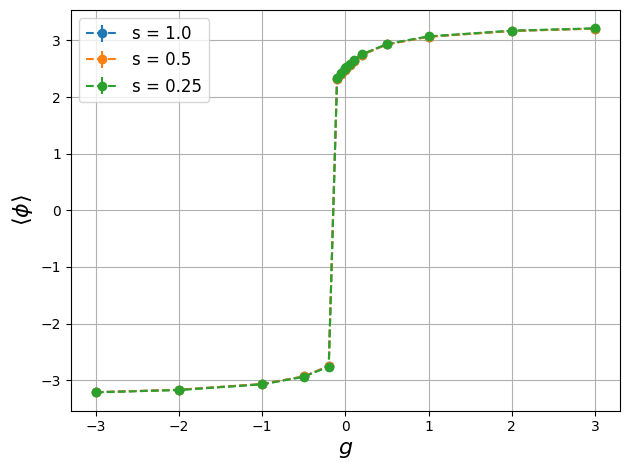

In [19]:
for k in phi.keys():
    plt.errorbar([v[2] for v in phi[k]], [v[0] for v in phi[k]], [v[1] for v in phi[k]], fmt='o--', label='s = ' + str(k))

plt.legend(fontsize=12)
#plt.xscale('log')
plt.xlabel(r'$g$', fontsize=16)
plt.ylabel(r'$\left\langle \phi \right\rangle$', fontsize=16)
plt.tight_layout()
plt.grid()
plt.savefig("phi.pdf")
plt.show()

### Plot of the magnetic susceptibility

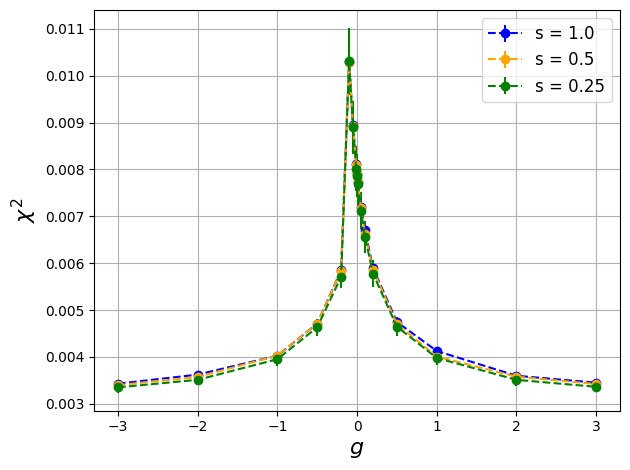

In [20]:
for k, c in zip(chi2.keys(), colors):
    xvals = [v[2] for v in chi2[k]]
    yvals = [v[0] for v in chi2[k]]
    errs = [v[1] for v in chi2[k]]
    plt.errorbar(xvals, yvals, errs, fmt='o--', label='s = ' + str(k), color=c)
    #plt.plot([xvals[yvals.index(max(yvals))], xvals[yvals.index(max(yvals))]], [min(yvals), max(yvals)], '--', color=c)

plt.legend(fontsize=12)
#plt.xscale('log')
plt.xlabel(r'$g$', fontsize=16)
plt.ylabel(r'$\chi^2$', fontsize=16)
plt.tight_layout()
plt.grid()
plt.savefig("chi2.pdf")
plt.show()

### Plot of the condensate

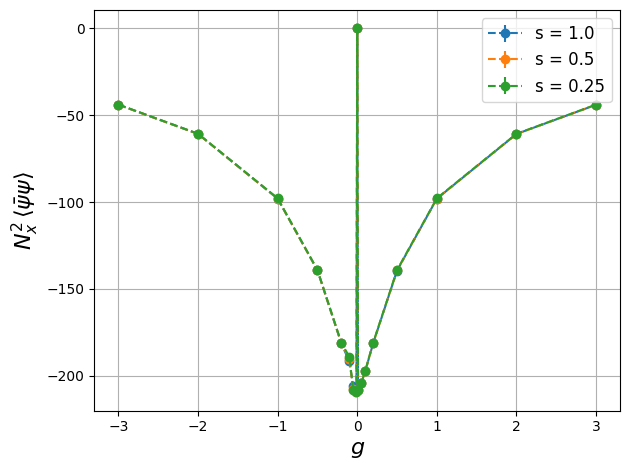

In [21]:
for k in cond.keys():
    Nx = Nx0/float(k)
    plt.errorbar([v[2] for v in cond[k]], [Nx*Nx*v[0] for v in cond[k]], [Nx*Nx*v[1] for v in cond[k]], fmt='o--', label='s = ' + str(k))

plt.legend(fontsize=12)
#plt.xscale('log')
plt.xlabel(r'$g$', fontsize=16)
plt.ylabel(r'$N_x^2 \, \left\langle \bar \psi \psi \right\rangle$', fontsize=16)
plt.tight_layout()
plt.grid()
plt.savefig("condensate.pdf")
plt.show()

### Plot of the physical quark mass

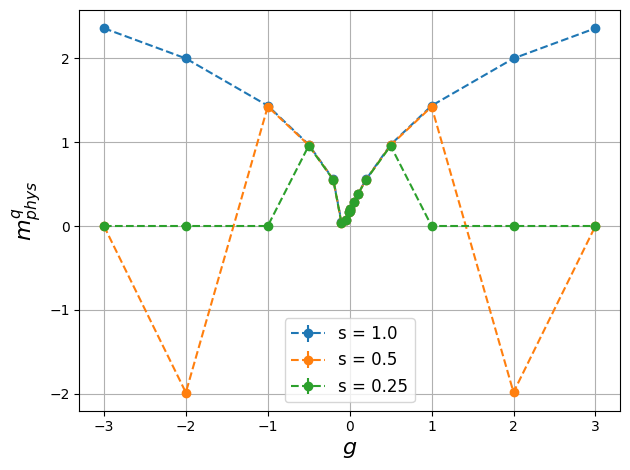

In [22]:
for k in mr.keys():
    Nx = Nx0/float(k)
    plt.errorbar([v[2] for v in mqphys[k]], [v[0] for v in mqphys[k]], [0 for _ in range(len(mqphys[k]))], fmt='o--', label='s = ' + str(k))

plt.legend(fontsize=12)
#plt.xscale('log')
plt.xlabel(r'$g$', fontsize=16)
plt.ylabel(r'$m^q_{phys}$', fontsize=16)
plt.tight_layout()
plt.grid()
plt.savefig("mqphys.pdf")
plt.show()

### Plot of the bosonic renormalised mass

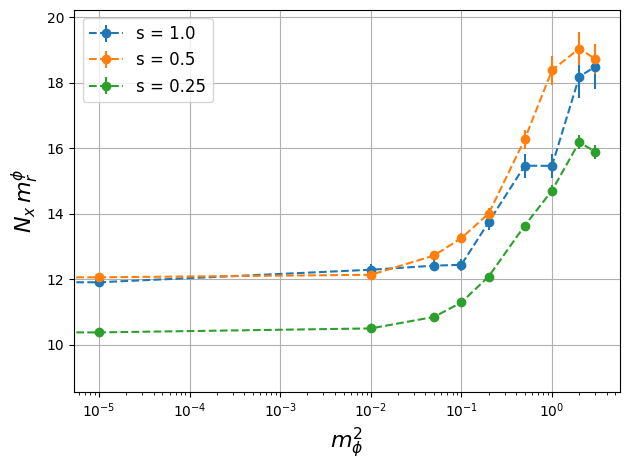

In [23]:
for k in mr.keys():
    Nx = Nx0/float(k)
    plt.errorbar([v[2] for v in mr[k]], [Nx*v[0] for v in mr[k]], [Nx*v[1] for v in mr[k]], fmt='o--', label='s = ' + str(k))

plt.legend(fontsize=12)
plt.xscale('log')
plt.xlabel(r'$m_\phi^2$', fontsize=16)
plt.ylabel(r'$N_x \, m^\phi_r$', fontsize=16)
plt.tight_layout()
plt.grid()
plt.savefig("mphir.pdf")
plt.show()

# Physical quark mass

In [13]:
from scipy.optimize import curve_fit as fit

####################################################
data_folder = "dataset2/s_1_0/conf1"
Nt = 16
plot = True
####################################################

def fitfuncSinh(x, m_re, A):
    return A * np.sinh(m_re*(Nt/2-x))

def fitToSinh(ydata, startidx, endidx, plot=False):
    yvals = ydata[startidx:endidx]
    xvals = np.array(range(startidx, endidx))

    fitparams = fit(fitfuncSinh, xvals, yvals, p0=[1e-2, 0])
    #print("Mass: ", abs(fitparams[0][0]))
        
    return fitparams[0]

params = toml.load("data/" + data_folder + "/input.toml") # read toml file with parameters
s = params['physics']['cutFraction'] # read cutoff
g = params['fermions']['yukawa_coupling']

data = read_csv("data/" + data_folder + "/data.csv")
timeslices = data['corr'].to_numpy(np.dtype('f8')).reshape((-1, Nt))

corr = np.average(timeslices, axis=0)

fitparams = fitToSinh(corr, 1, Nt, plot)

print("s:", s, " g:", g)
print("Number of data points:", timeslices.shape[0])
print("Nt:", Nt)
print("Mass =", fitparams[0])

FileNotFoundError: [Errno 2] No such file or directory: 'data/dataset2/s_1_0/conf1/input.toml'

In [ ]:
plt.plot(range(1, Nt), corr[1:Nt])
plt.xlabel(r'$N_t$')
plt.title("Correlator")
plt.tight_layout()
plt.savefig("mass.pdf")
plt.show()

In [ ]:
plt.plot(range(1, Nt), corr[1:Nt], label="data")
xvals = np.linspace(0, Nt, 1000)
plt.plot(xvals, fitfuncSinh(xvals, fitparams[0], fitparams[1]), label='fit')
plt.legend()
plt.xlabel(r'$N_t$')
plt.title("Correlator")
plt.tight_layout()
plt.savefig("mass.pdf")
plt.show()

Compute expected mass from background fields

In [ ]:
def expectedM(m0, g, sigma, pi):
    r2 = sigma**2 + pi[0]**2 + pi[1]**2 + pi[2]**2
    denom = 2*(g*sigma + m0 + 1)
    sqrroot = np.sqrt((g**2*r2 + 2*m0*(g*sigma + 1) + 2*g*sigma + m0**2 + 2)**2 - 4*(g*sigma+m0+1)**2)
    num = -sqrroot + g**2*r2 + 2*g*m0*sigma + 2*g*sigma + m0**2 + 2*m0 + 2
    return -np.log(num/denom)

mq0 = 0.2
yukawa_coupling = 0.1
sigma = 0.16
pi = [0, 0, 0]

print("Expected mass with phi =", np.concatenate(([sigma], pi)), ":", expectedM(mq0, yukawa_coupling, sigma, pi))

# Renormalised boson mass

In [21]:
from correlations import *
from read_in_data import *
from mass_fit import *

In [ ]:
####################################################
f = "dataset1/s_1_0/conf1"
Nt = 16
Nx = 16
####################################################
volume = (Nt, Nx)

In [ ]:
S_t = get_time_slices_from_timeslicefile("data/" + f + "/slice.dat", field_axis=0, return_all=False)
val, err = get_phys_quark_mass_via_timeslices(S_t,volume)
print("mr:", val, err)

# Mean Field equations of motion

Reset data arrays

In [ ]:
sigma_vals = []
sigma_errs = []
tr_vals = []
tr_errs = []
cutFractions = []

In [39]:
rcParams['text.usetex'] = True

####################################################
folders = ["s1"]
mypath = "data/"
plot_trace = True
####################################################


c = 0
for fold in folders:
    s = []
    data = [] # each element will be a triple (s, sigma, err_sigma)
    data_trace = [] # each element will be a triple (s, condensate, err_condensate)
    for f in os.listdir(mypath + fold):
        
        full_path = mypath + fold + "/" + f + "/"   
        
        params = toml.load(full_path + "/input.toml")
        s = float(params['physics']['cutFraction'])
       
        filedata = read_csv(full_path + "traces.csv")
        N = len(filedata['sigma'])
    
        # vals
        sigma = np.average(filedata['sigma'].to_numpy())
        tr = np.average(filedata['tr'].to_numpy())
        
        print("s =", s, " <|sigma|> = ", sigma, " <|psibar psi|> = ", tr)
        
        # errs
        sigma_err = np.std(filedata['sigma'].to_numpy()) / np.sqrt(N-1)
        tr_err = np.std(filedata['tr'].to_numpy()) / np.sqrt(N-1)
                    
        data.append((s, sigma, sigma_err))
        data_trace.append((s, tr, tr_err))
    
    data = sorted(data, key=lambda x: x[0])
    data_trace = sorted(data_trace, key=lambda x: x[0])
                    
    for el in data:
        cutFractions.append(el[0])
        sigma_vals.append(el[1])
        sigma_errs.append(el[2])
    
    for el in data_trace:
        tr_vals.append(el[1])
        tr_errs.append(el[2])

    plt.errorbar(cutFractions, sigma_vals, yerr=sigma_errs, fmt='o', color=colors[c])
    if plot_trace:
        plt.errorbar(cutFractions, [t/1 for t in tr_vals], yerr=[t/1 for t in tr_errs], fmt='o')

    c += 1
                    
plt.show()



FileNotFoundError: [Errno 2] No such file or directory: 'data/s1'